# FAIR and scalable management of small-angle X-ray scattering data  
## Module 3: Data analysis and visualisation
### 3.2: Analysis

> Authors: Torsten Giess, Selina Itzigehl, Jan Range, Johanna Bruckner, Juergen Pleiss  
> Last modified: 10.05.2022

---

### **Abstract** <a class="anchor" name="abstract"></a>

Using established packages numpy (version 1.22.1) and pandas (version 1.4.1), as well as packages from the Python 3 standard libary, this notebook provides the means to determine the lyotropic liquid-crystalline phase and lattice parameter _a_ from the peak centers of a diffractogram by calibration of scattering vectors and calculation of lattice plane distances. 

---

### **Table of Contents** <a class="anchor" name="table_of_contents"></a>

- [Abstract](#abstract)
- [Workflow](#workflow)
    - [User guide](#user_guide)
    - [Preparation](#preparation)
    - [Analysis with Python](#analysis)
- [Disclosure](#disclosure)

---

### **Workflow** <a class="anchor" name="workflow"></a>

Following is the workflow for Module 3.2: Analysis of FAIR and scalable management of small-angle X-ray scattering data.

#### **User guide** <a class="anchor" name="user_guide"></a>

This notebook can be used to determine the lyotropic liquid-crystalline phase as well as the corresponding lattice parameter _a_ from the peak centers obtained from previous evaluation of diffractograms by providing calibration and calculation of required values.

#### **Preparation** <a class="anchor" name="preparation"></a>

This section contains the necessary preparations for using this module. Code cells in this section are required regardless of which functionality of this notebook is used. First, the required packages from the [Python 3 standard library](https://docs.python.org/3/library/), the Python Package Index ([PyPI](https://pypi.org/)), and *ad hoc* modules of this work are imported. Then, both current time and path are retrieved and stored in the desired formats.

In [42]:
print("Importing standard library packages.")
from datetime import date
from pathlib import Path
from typing import List
print ("Done.")

Importing standard library packages.
Done.


In [43]:
print("Importing PyPI packages.")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyaniml import AnIMLDocument, Category, Parameter
from sklearn.metrics import r2_score
print ("Done.")

Importing PyPI packages.
Done.


In [44]:
print("Importing local packages.")
from modules.infer_type import infer_type
from modules.originreader import LorentzianReader
print("All done.")

Importing local packages.
All done.


In [45]:
date_suffix = str(date.today()).replace("-", "")[2:]

In [46]:
cwd = Path.cwd()
path_to_datasets = cwd / "./datasets/"

In [47]:
def calculate_scattering_vector(d: float) -> float:
    q = (2 * np.pi) / (d / 10)
    return q

def calculate_linear_regression(m: float, x: float, b: float) -> float:
    y = m * x + b
    return y

def calculate_lattice_plane(q: float) -> float:
    d = (2 * np.pi) / q
    return d

def calculate_lattice_ratio(d: float, d_0: float) -> float:
    d_ratio = d / d_0
    return d_ratio

def determine_phase(d_ratios: list) -> bool:
    H1 = [
        (1 / np.sqrt(3)),
        (1 / np.sqrt(4)),
        (1 / np.sqrt(7)),
        (1 / np.sqrt(9)),
    ]
    V1 = [
        (1 / np.sqrt(2)),
        (1 / np.sqrt(3)),
        (1 / np.sqrt(4)),
        (1 / np.sqrt(5)),
    ]
    La = [(1 / 2), (1 / 3), (1 / 4), (1 / 5)]
    
    for i, j in enumerate(d_ratios):
        if (abs(d_ratios[i] - H1[i])) < 0.03:
            return "hexagonal"
        elif (abs(d_ratios[i] - V1[i])) < 0.03:
            return "cubic"
        elif (abs(d_ratios[i] - La[i])) < 0.03:
            return "lamellar"
        else:
            return "indeterminate"

def calculate_a_H1(d: float, h: int, k: int) -> float:
    a_H1 = d * np.sqrt((4/3)*((h**2 + k**2 + (h * k))))
    return a_H1


def calculate_a_V1(d: float, h: int, k: int, l: int) -> float:
    a_V1 = d * (np.sqrt((h ** 2) + (k ** 2) + (l ** 2)))
    return a_V1

def d_reciprocal(peak_center):
    d_reciprocal = ((peak_center)/(2*np.pi))
    return d_reciprocal

def sqrt_miller(h, k, l):
    sq_root = np.sqrt(h**2 + k**2 + l**2)
    return sq_root

---

#### **Analysis with Python** <a class="anchor" name="analysis"></a>

lorem ipsum...

Open AnIML document to later append analysis results from this Notebook.

In [48]:
path_to_AnIML_file = path_to_datasets / f"processed/fairsaxs_220502.animl"

In [49]:
with path_to_AnIML_file.open("r") as f:
    xml_string = f.read()
    animl_doc = AnIMLDocument.fromXMLString(xml_string)

Access the Result of the ExperimentStep this Analysis belongs to.

In [50]:
experiment_step = animl_doc.experiment_step_set.experiment_steps[0].result

Create the new Category for the analysis results.

In [51]:
new_category = Category(name="Analyses")

Import Lorentzian data from Origin TXT output file. For several measurement datasets select the respective folder.

In [52]:
available_txt_files = [file for file in (path_to_datasets / "raw/OTAB_measurement_data/Lorentzian_fitting_data").glob("*.txt")]
print([file.name for file in available_txt_files])

['CholPal_20220214_lorentz.txt', 'OTAB_078wtp_T058_lorentz.txt', 'OTAB_078wtp_T060_lorentz.txt', 'OTAB_082wtp_T025_lorentz.txt', 'OTAB_093wtp_T025_lorentz.txt']


In [53]:
dict_of_df = {}
i=0
for file in available_txt_files:
    dict_of_df[available_txt_files[i].name] = LorentzianReader(available_txt_files[i]).get_xc_dataframe()
    i += 1
print(dict_of_df.keys())

10:33:29 - modules.originreader - DEBUG: Constructor called, 'LorentzianReader'@0x1ee774b45b0 initialised.
10:33:29 - modules.originreader - DEBUG: Data extracted from 'C:\Users\ac138949\Documents\GitHub\SAXS-workflow\notebooks\datasets\raw\OTAB_measurement_data\Lorentzian_fitting_data\CholPal_20220214_lorentz.txt'.
10:33:29 - modules.originreader - DEBUG: Destructor called, 'LorentzianReader'@0x1ee774b45b0 deleted.
10:33:29 - modules.originreader - DEBUG: Constructor called, 'LorentzianReader'@0x1ee774b45b0 initialised.
10:33:29 - modules.originreader - DEBUG: Data extracted from 'C:\Users\ac138949\Documents\GitHub\SAXS-workflow\notebooks\datasets\raw\OTAB_measurement_data\Lorentzian_fitting_data\OTAB_078wtp_T058_lorentz.txt'.
10:33:29 - modules.originreader - DEBUG: Destructor called, 'LorentzianReader'@0x1ee774b45b0 deleted.
10:33:29 - modules.originreader - DEBUG: Constructor called, 'LorentzianReader'@0x1ee774b45b0 initialised.
10:33:29 - modules.originreader - DEBUG: Data extract

Calculate the scttering vectors for calibration from literature lattice plane distances.

In [54]:
d_from_literature = [52.49824535, 26.24912267, 17.49941512]
q_cholpal_literature = [calculate_scattering_vector(d) for d in d_from_literature]
print(q_cholpal_literature)

[1.1968372019465192, 2.3936744043489915, 3.590511605155628]


Calibrate the peak centers of a measurement (element from `available_txt_files`) with the calibration line. Then calculate the lattice plane ratio from `q_corrected`:

In [55]:
slope, intercept = np.polyfit(
    x=dict_of_df[available_txt_files[0].name]["value"].tolist(),
    y=q_cholpal_literature,
    deg=1
)
q_corrected = [calculate_linear_regression(slope, value, intercept) for value in
               dict_of_df[available_txt_files[3].name]["value"].tolist()]
print(q_corrected)

[2.5809534458860877, 4.47927497694825]


Add corrected q values to the AnIML document:

In [56]:
subcategory = Category(name="q_corrected")

In [57]:
for i, q in enumerate(q_corrected):
    new_parameter = Parameter(
        name=f"q_corrected of peak {i+1}",
        parameter_type=infer_type(q),
        value=q
    )
    subcategory.add_content(new_parameter)

In [58]:
new_category.add_content(subcategory)

In [59]:
d_measured = [calculate_lattice_plane(q) for q in q_corrected]
print(d_measured)

[2.43444348722937, 1.4027237308526097]


In [60]:
subcategory = Category(name="d_measured")

In [61]:
for i, d in enumerate(d_measured):
    new_parameter = Parameter(
        name=f"d_measured of peak {i+1}",
        parameter_type=infer_type(d),
        value=d
    )
    subcategory.add_content(new_parameter)

In [62]:
new_category.add_content(subcategory)

To determin the lyotropic liquid-crystalline phase at hand, calculate the _d_ ratios. With the _d_ ratio(s), the phase and respective lattice parameter _a_ are determined:

In [63]:
d_ratio = [calculate_lattice_ratio(d, d_measured[0]) for d in d_measured[1:]]
print(d_ratio)

[0.576198929328626]


In [64]:
subcategory = Category(name="d_ratio")

In [65]:
for i, d in enumerate(d_ratio):
    new_parameter = Parameter(
        name=f"d_ratio of peaks {i+2} and 1",
        parameter_type=infer_type(d),
        value=d
    )
    subcategory.add_content(new_parameter)

In [66]:
new_category.add_content(subcategory)

In [67]:
phase = determine_phase(d_ratio)
if phase == "hexagonal":
    h = [1, 1, 2, 2, 3]
    k = [0, 1, 0, 1, 0]
    a_hex = []
    for i, j in enumerate(d_measured):
        a_i = calculate_a_H1(d_measured[i], h[i], k[i])
        a_hex.append(a_i)
    phase_information = [phase, (np.mean(a_hex))]

elif phase == "cubic":
    h = [1, 1, 2, 2, 2]
    k = [0, 1, 0, 1, 2]
    l = [0, 1, 0, 1, 2]
    a_cub = []
    for i, j in enumerate(d_measured):
        a_i = calculate_a_V1(d_measured[i], h[i], k[i], l[i])
        a_cub.append(a_i)
    phase_information = [phase, (np.mean(a_cub))]

elif phase == "lamellar":
    phase_information = [phase, d_measured[0]]

else:
    phase_information = ["indeterminate", "-"]

In [68]:
print(phase_information)

['hexagonal', 2.8082503335314177]


In [69]:
subcategory = Category(name="phase information")

In [70]:
new_parameter = Parameter(
    name=f"phase",
    parameter_type=infer_type(phase_information[0]),
    value=phase_information[0]
)
subcategory.add_content(new_parameter)

In [71]:
new_parameter = Parameter(
    name=f"lattice parameter",
    parameter_type=infer_type(phase_information[1]),
    value=phase_information[1]
)
subcategory.add_content(new_parameter)

In [72]:
new_category.add_content(subcategory)

If phase is not cubic, add everything to the existing AnIML document and serialize it (else, skip to Cubic phase specification):

In [73]:
experiment_step.add_result(new_category)

In [74]:
xml_string = animl_doc.toXML()

In [75]:
with path_to_AnIML_file.open("w") as f:
    f.write(xml_string)
del animl_doc, xml_string
print(f"Successfully created AnIML document.")

Successfully created AnIML document.


---

#### **Cubic phase specification** <a class="anchor" name="phases"></a>

As the multiple scattering maxima if the cubic LLC phase can be assigned to various Miller indices, different space groups are possible. This section enables checking for the best fit by plotting $d^{-1}$ vs. $\sqrt{h^2+k^2+l^2}$.

First, a measurement file is selected and the assigned Miller indices stored in lists `h`, `k` and `l`:

In [76]:
h = [2, 2, 3]
k = [1, 2, 1]
l = [1, 0, 0]

In [77]:
data = pd.read_table(path_to_datasets / "raw/OTAC_measurement_data/Lorentzian_fitting_data/OTAC_094wtp_T050_lorentz.txt",
                     delimiter="\t",
                     usecols=(1,2),
                     names=("key", "value"),
                     header=1,
                     engine="python"
                    )

peak_centers = data[data["key"] == "xc"]
scattering_vector = peak_centers["value"].values.tolist()

x = [sqrt_miller(h[index], k[index], l[index]) for index, item in enumerate(h)]
y = [d_reciprocal(_) for _ in scattering_vector]
print(x)
print(y)

[2.449489742783178, 2.8284271247461903, 3.1622776601683795]
[0.3913317656237832, 0.46553298319208664, 0.7574517967123793]


The calculated values for $d^{-1}$ plotted against the respective $\sqrt{h^2+k^2+l^2}$ and fitted by linear regression. The $R^2$-value is calculated for assessment of the fit quality:

In [78]:
coef = np.polyfit(x, y, 1)
fit = np.poly1d(coef)
r2 = r2_score(y, fit(x))

For visualization, the fit is plotted:

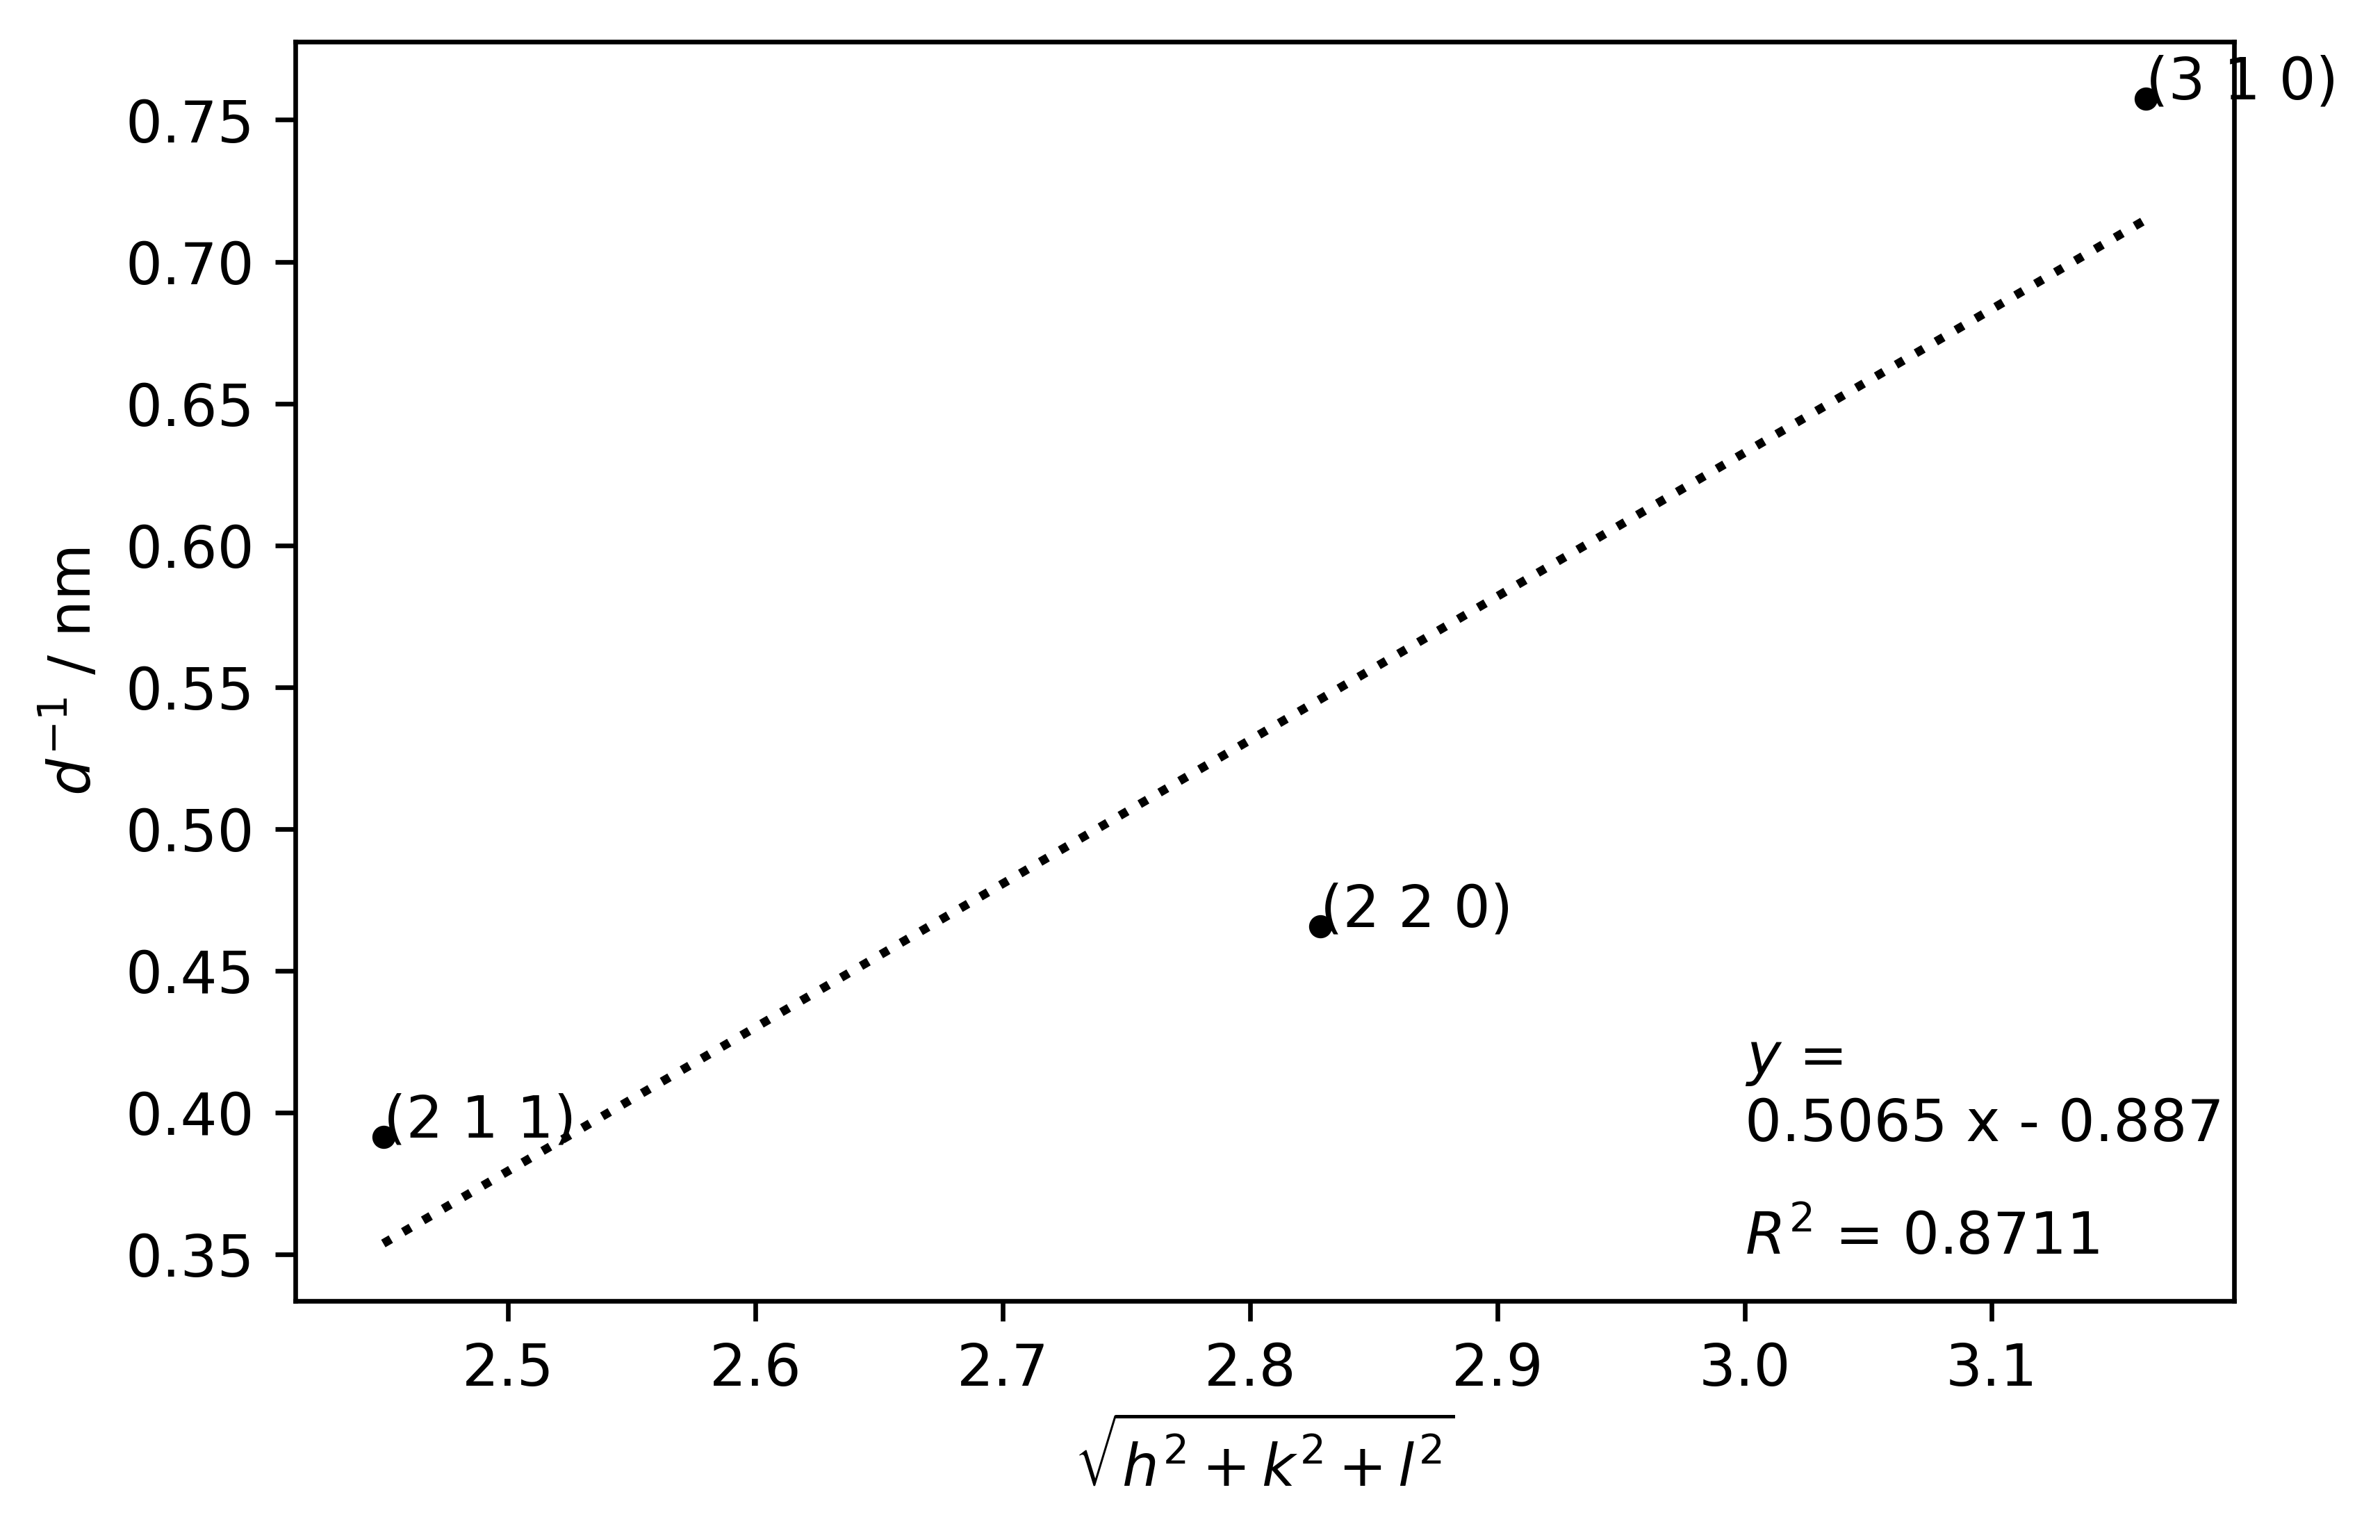

In [79]:
fig = plt.figure(dpi=600)
ax = fig.add_subplot()
ax.set(xlabel="$\sqrt{h^2+k^2+l^2}$",
       ylabel="$d^{-1}$ / nm"
       )
ax.plot(x, y, marker=".", linestyle="None", color="black")
ax.plot(x, fit(x), marker="None", linestyle=":", color="black")

for i, label in enumerate(h):
    ax.annotate(("("+str(h[i])+" "+str(k[i])+" "+str(l[i])+")"), (x[i], y[i]))
    
ax.text(3.0, 0.39, f"$y$ = {str(fit)}")
ax.text(3.0, 0.35, f"$R^2$ = {str(round(r2, 4))}")

plt.show()

Optionally, add exact cubic phase to the AnIML document and serialize it:

In [37]:
exact_cubic_phase = ""

In [38]:
for category in experiment_step.results[1].content:
    if category.name == "phase information":
        new_parameter = Parameter(
            name=f"exact cubic phase",
            parameter_type=infer_type(exact_cubic_phase),
            value=exact_cubic_phase
        )
        category.add_content(new_parameter)
    else:
        pass

In [39]:
xml_string = animl_doc.toXML()

In [41]:
with path_to_AnIML_file.open("w") as f:
    f.write(xml_string)
del animl_doc, xml_string
print(f"Successfully created AnIML document.")

Successfully created AnIML document.


---

### **Disclosure** <a class="anchor" name="disclosure"></a>

**Contributions**

If you wish to contribute to the FAIR Chemistry project, find us on [GitHub](https://github.com/FAIRChemistry)!

**MIT License**

Copyright (c) 2022 FAIR Chemistry

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.